In [228]:
from pandas_datareader import data as pdr
import datetime as dt
import pandas as pd
import yfinance as yf
import requests
from  calculate_selic import calculate_average_selic_annual
from asset_download import stocks_dataframe
from plot_EF import plot_efficient_frontier

from pypfopt import EfficientFrontier, EfficientSemivariance, expected_returns, risk_models, plotting
from pypfopt.cla import CLA
from sklearn.linear_model import LinearRegression

from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import scipy.cluster.hierarchy as shc
from scipy import stats
import plotly.express as px
import pickle

In [5]:
start = dt.date(2015,1,1)
end = dt.date.today()
#end = 10
type(end) == dt.date

True

In [126]:
stocks_cod = ['ABEV3','PETR3' ,'MGLU3','ITUB3','ALPA3', 'VIVT3', 'WEGE3', 'VALE3', 'BBAS3']
stocks_cod = [stock +'.SA' for stock in stocks_cod]
stocks_cod

['ABEV3.SA',
 'PETR3.SA',
 'MGLU3.SA',
 'ITUB3.SA',
 'ALPA3.SA',
 'VIVT3.SA',
 'WEGE3.SA',
 'VALE3.SA',
 'BBAS3.SA']

In [135]:
 def stocks_dataframe(start, end = 0, *stocks_id:list):   
    
    if end == 0:
        end = dt.date.today()
        
    
    # convert string date in datetime
    start = dt.datetime.strptime(start, '%d/%m/%Y')
    
    if type(end) != dt.date:
        end  = dt.datetime.strptime(end, '%d/%m/%Y')
    
    stock_data = pd.DataFrame()
    
   
        
        # iterate stocks args  
    for i in stocks_id:


        for asset in i:

            try:
                # get close data stocks in yahoo finance API
                close = yf.download(asset, start=start, end=end)['Adj Close']

                # add adj close value
                stock_data[asset] = close
            except Exception as e:
                print(f"Error downloading data for {asset}: {str(e)}")


    stock_data.fillna(0, inplace = True)
    return stock_data

In [165]:
day = 365 * 3
date___= dt.datetime.strftime(dt.date.today() - dt.timedelta(days = day),"%d/%m/%Y")
data = stocks_dataframe(date___,0,stocks_cod)
columns = data.columns
index = data.index

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [166]:
data

,ABEV3.SA,PETR3.SA,MGLU3.SA,ITUB3.SA,ALPA3.SA,VIVT3.SA,WEGE3.SA,VALE3.SA,BBAS3.SA
Date,,,,,,,,,
2020-06-15,11.905569,8.984289,16.338261,21.268507,22.613514,39.248383,21.269693,39.251118,26.567221
2020-06-16,11.754867,9.355124,16.375479,21.715328,22.633280,39.945766,21.505116,40.351143,26.912670
2020-06-17,12.206976,9.376195,16.670732,21.911926,24.036743,40.164726,22.177750,40.941223,27.716034
2020-06-18,12.127192,9.523685,17.293495,22.474920,24.066393,40.943203,22.163338,40.919369,27.635696
2020-06-19,12.269032,9.388837,17.715288,23.583027,24.511152,41.316223,22.201775,40.190872,27.266144
...,...,...,...,...,...,...,...,...,...
2023-06-05,14.410000,28.914202,3.890000,23.120001,10.980000,41.270000,37.630001,67.379997,44.711830
2023-06-06,14.820000,29.499853,3.990000,23.190001,11.010000,42.560001,38.200001,67.599998,45.228271
2023-06-07,14.850000,30.416117,3.880000,23.200001,11.140000,42.430000,38.150002,68.669998,45.208408


In [167]:
def replaceZeroes(data):
    min_nonzero = np.min(data[np.nonzero(data)])
    data[data == 0] = min_nonzero
    return data

data = pd.DataFrame(columns = columns, data = replaceZeroes(data.values), index = index)
returns = data.pct_change().iloc[1:].apply(lambda x: np.log1p(x)).dropna()

# annual returns
mean = returns.mean() *252

# deviation
sigma =  returns.std(axis = 0) * np.sqrt(252)

cov_matrix = returns.cov() * 252
cov_matrix

,ABEV3.SA,PETR3.SA,MGLU3.SA,ITUB3.SA,ALPA3.SA,VIVT3.SA,WEGE3.SA,VALE3.SA,BBAS3.SA
ABEV3.SA,0.081116,0.036932,0.039235,0.036740,0.023416,0.021185,0.030313,0.009398,0.038401
PETR3.SA,0.036932,0.170160,0.039534,0.053113,0.018773,0.014178,0.024406,0.046483,0.078363
MGLU3.SA,0.039235,0.039534,0.458229,0.042653,0.098421,0.027358,0.070779,0.019224,0.052578
ITUB3.SA,0.036740,0.053113,0.042653,0.085988,0.024128,0.019745,0.027321,0.022962,0.059360
ALPA3.SA,0.023416,0.018773,0.098421,0.024128,0.205656,0.016433,0.038606,0.005670,0.023763
VIVT3.SA,0.021185,0.014178,0.027358,0.019745,0.016433,0.050692,0.017676,0.001753,0.022618
WEGE3.SA,0.030313,0.024406,0.070779,0.027321,0.038606,0.017676,0.124081,0.019799,0.026066
VALE3.SA,0.009398,0.046483,0.019224,0.022962,0.005670,0.001753,0.019799,0.121427,0.023009
BBAS3.SA,0.038401,0.078363,0.052578,0.059360,0.023763,0.022618,0.026066,0.023009,0.103006


In [168]:
returns.head()

,ABEV3.SA,PETR3.SA,MGLU3.SA,ITUB3.SA,ALPA3.SA,VIVT3.SA,WEGE3.SA,VALE3.SA,BBAS3.SA
Date,,,,,,,,,
2020-06-16,-0.012739,0.040447,0.002275,0.020791,0.000874,0.017612,0.011008,0.027640,0.012919
2020-06-17,0.037740,0.002250,0.017870,0.009013,0.060162,0.005466,0.030799,0.014518,0.029414
2020-06-18,-0.006557,0.015608,0.036676,0.025369,0.001233,0.019197,-0.000650,-0.000534,-0.002903
2020-06-19,0.011628,-0.014260,0.024098,0.048127,0.018312,0.009069,0.001733,-0.017964,-0.013463
2020-06-22,0.019321,-0.018574,-0.007027,-0.041786,0.007232,-0.023031,-0.013288,-0.003086,-0.020840


In [169]:
def return_portfolio(w, ret):
    # return capm
    return  (w* ret).sum()

    #return  expected_returns.capm_return(data)

def cov_portfolio(w, cov_matrix):
    # risk calculation    
    return np.sqrt(np.dot(w.T, (np.dot(cov_matrix, w))))
    #return risk_models.CovarianceShrinkage(data).ledoit_wolf()


In [ ]:
"""
def calculate_average_selic_annual(year1, year2 = 0):
    
    import datetime as dt
    import pandas as pd
    
    if year2 == 0:
        year2 = dt.date.today().year
        
    if year1 > year2:
        
        raise ValueError("Primeiro ano deve ser menor que o segundo ano.")
        
    # api extract selic
    serie = 432
    url = f'https://api.bcb.gov.br/dados/serie/bcdata.sgs.{serie}/dados?formato=json'
    data = pd.read_json(url)
    
    # convert to datetime
    data['data'] = pd.to_datetime(data['data'], dayfirst = True)
    
    # year column, grouping by year and aggregate average
    data['ano'] = data['data'].dt.year
    selic_annual = data.groupby('ano')['valor'].mean()
    
    # average selic rate of the years
    rate_w_risk = selic_annual[(selic_annual.index > year1) & (selic_annual.index < year2)].mean()
    
    return round(rate_w_risk/100,4)

In [170]:
tax_w_risk = calculate_average_selic_annual(2020)
tax_w_risk

0.0854

In [171]:
columns = [x for x in data.columns]
lista = ['Retorno P %', 'Risco %', 'Indice Sharpe']
columns.extend(lista)

simulacao = pd.DataFrame(columns=[columns])
simulacao

,ABEV3.SA,PETR3.SA,MGLU3.SA,ITUB3.SA,ALPA3.SA,VIVT3.SA,WEGE3.SA,VALE3.SA,BBAS3.SA,Retorno P %,Risco %,Indice Sharpe


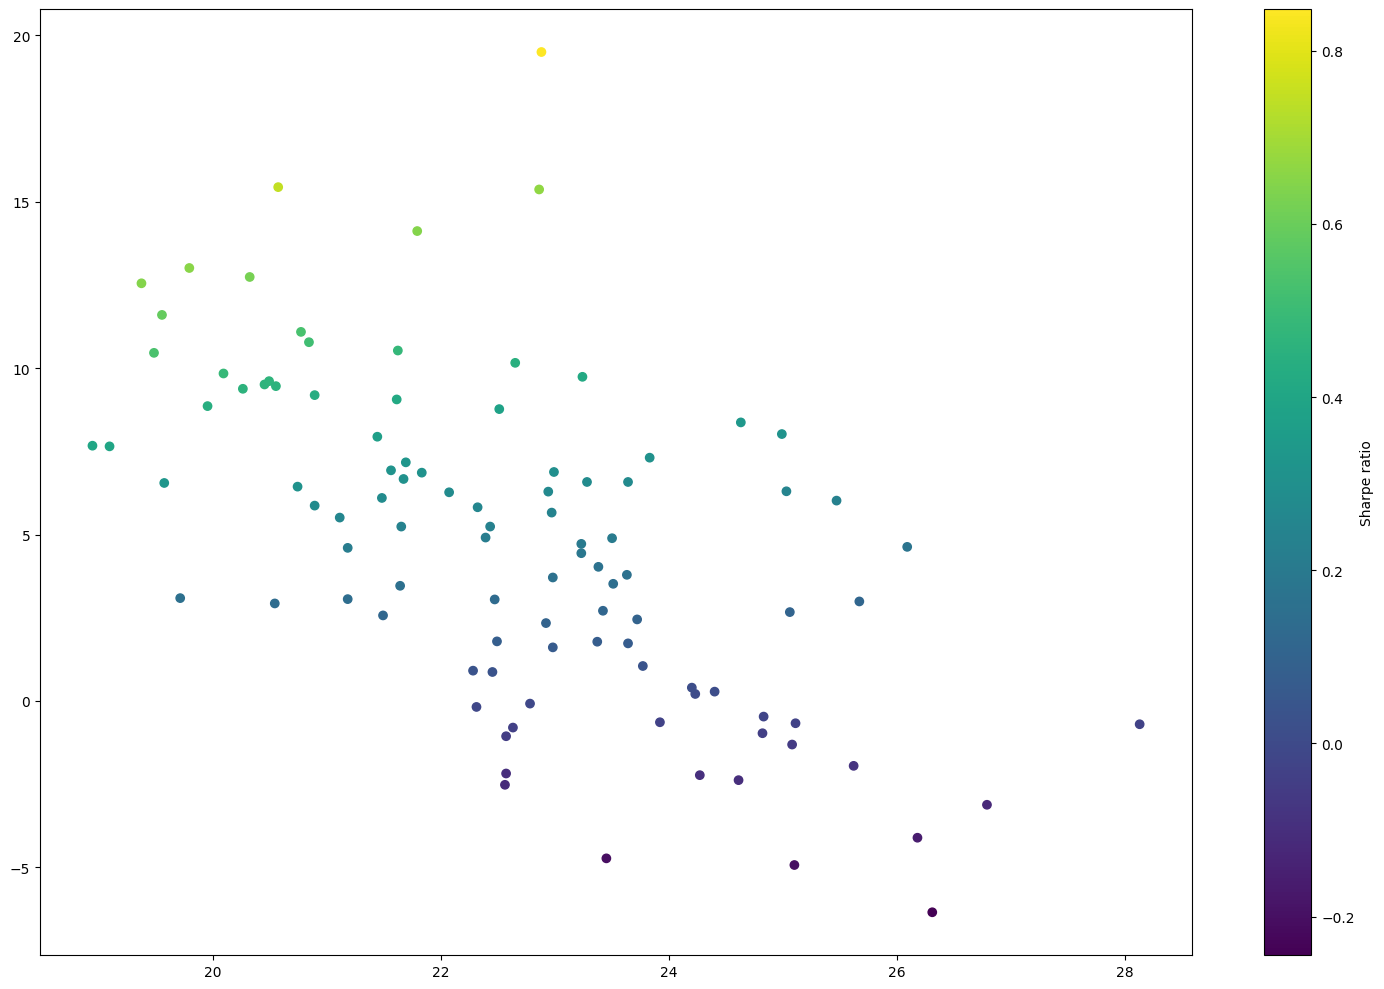

In [172]:
N = 100

for x in range (N):
    
    np.random.seed(x)
    
    # pesos aleatorios e normalizando
    w = np.random.random(9)
    w = np.array(w/w.sum())
    
    sigma = cov_portfolio(w, cov_matrix)*100
    
    ret = return_portfolio(w, mean).sum() *100
    sharp_r = (ret - tax_w_risk) / sigma

    simulacao.loc[x] = [round(w[0], 3), round(w[1],3), round(w[2],3),round(w[3],3),round(w[4],3),
                        round(w[5],3), round(w[6],3), round(w[7],3), round(w[8],3),
                        round(ret,2), round(sigma,2), round(sharp_r, 4)]

    
# Gráfico
plt.figure(figsize= (15,10))
plt.scatter(simulacao['Risco %'], simulacao['Retorno P %'], c = simulacao['Indice Sharpe'])
plt.colorbar(label = 'Sharpe ratio')
#plt.legend(bbox_to_anchor=(1.3, 0.6)) 
plt.tight_layout()   


In [173]:
maxi = simulacao['Indice Sharpe'].max()[0]
maxi

0.8483

In [174]:
expected_r = expected_returns.capm_return(data)
estimative = risk_models.CovarianceShrinkage(data).ledoit_wolf()
ef1 = EfficientFrontier(expected_r, estimative)
ef1.max_sharpe()
ret_tangent, std_tangent, _ = ef1.portfolio_performance(verbose = True)

Expected annual return: 11.2%
Annual volatility: 21.4%
Sharpe Ratio: 0.43


In [175]:
#fig, ax = plt.subplots()

def ploty_efficient_frontier(std, ret, expected_returns, cov_matrix, n_assets, n_samples):
    
    
    plt.scatter(std, ret, marker="*", s=100, c="r", label="Portfolio")

    n_samples = n_samples
    w = np.random.dirichlet(np.ones(n_assets), n_samples)
    rets_s = w.dot(expected_returns)
    stds_s = np.sqrt(np.diag(w @ cov_matrix @ w.T))
    sharpes = rets_s / stds_s
    plt.scatter(stds_s, rets_s, marker=".", c=sharpes, cmap="viridis_r")
    plt.colorbar(label = 'Sharpe ratio')
    plt.title("Fronteira Eficiente")
    plt.legend()
    plt.tight_layout();
    plt.clf()
    return rets_s, stds_s, sharpes

In [176]:
ef2 = CLA(expected_r, estimative)
ef2.min_volatility()
ef2.portfolio_performance(verbose = True,risk_free_rate=tax_w_risk)

Expected annual return: 8.2%
Annual volatility: 17.3%
Sharpe Ratio: -0.02


(0.08162723074021115, 0.17278344683015753, -0.02183524712004041)

In [177]:
ef3 = EfficientFrontier(expected_r, estimative)
ef3.max_quadratic_utility()
ef3.portfolio_performance(verbose = True, risk_free_rate=tax_w_risk)

Expected annual return: 13.7%
Annual volatility: 28.5%
Sharpe Ratio: 0.18


(0.13681015112498124, 0.2853853575203274, 0.1801429182340562)

In [178]:
w_sharpe = dict(ef1.clean_weights())
w_risk = dict(ef2.clean_weights())
w_return = dict(ef3.clean_weights())

values_sharpe = np.dot(list(w_sharpe.values()),1000)
values_risk = np.dot(list(w_risk.values()),1000)
values_return = np.dot(list(w_return.values()),1000)
#################################################

In [475]:
def capm_calc(columns: list, betas: dict, weights: dict, risk_market, tax_free_risk):
    
    

    sum_betas = 0
    
    for i in columns:

        sum_betas += (betas[i] * weights[i])

    capm = tax_free_risk + sum_betas * (risk_market - tax_free_risk)
    return capm

ibov_mean = float(ibov_rent.mean())

capm_calc(list(data.columns), dict_betas, w_sharpe, ibov_mean, tax_w_risk)

0.18727586408492441

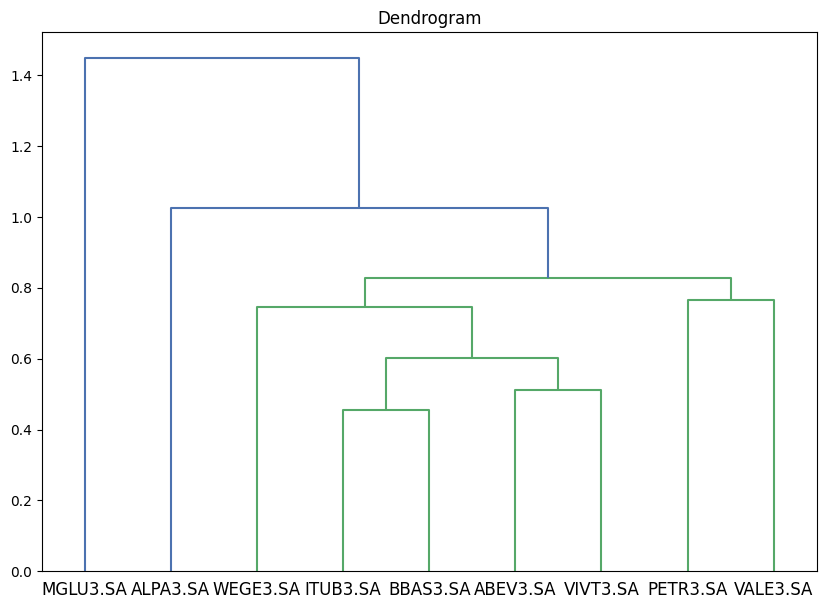

In [179]:
# oTIMIZAÇÃO PORTFOLIO HRP
plt.figure(figsize=(10, 7))  
plt.title("Dendrogram")

clusters = shc.linkage(returns.T, method='ward', metric='euclidean')

dendogram = shc.dendrogram(clusters, labels=returns.columns)

In [180]:
def matrix_seriation(returns: pd.DataFrame):

    matrix_cov = returns.cov()

    dendogram = sns.clustermap(matrix_cov, method='ward', metric='euclidean')
    
    seriation = dendogram.dendrogram_col.reordered_ind
    columns_seriation = returns.columns[seriation]

    return (matrix_cov, columns_seriation)

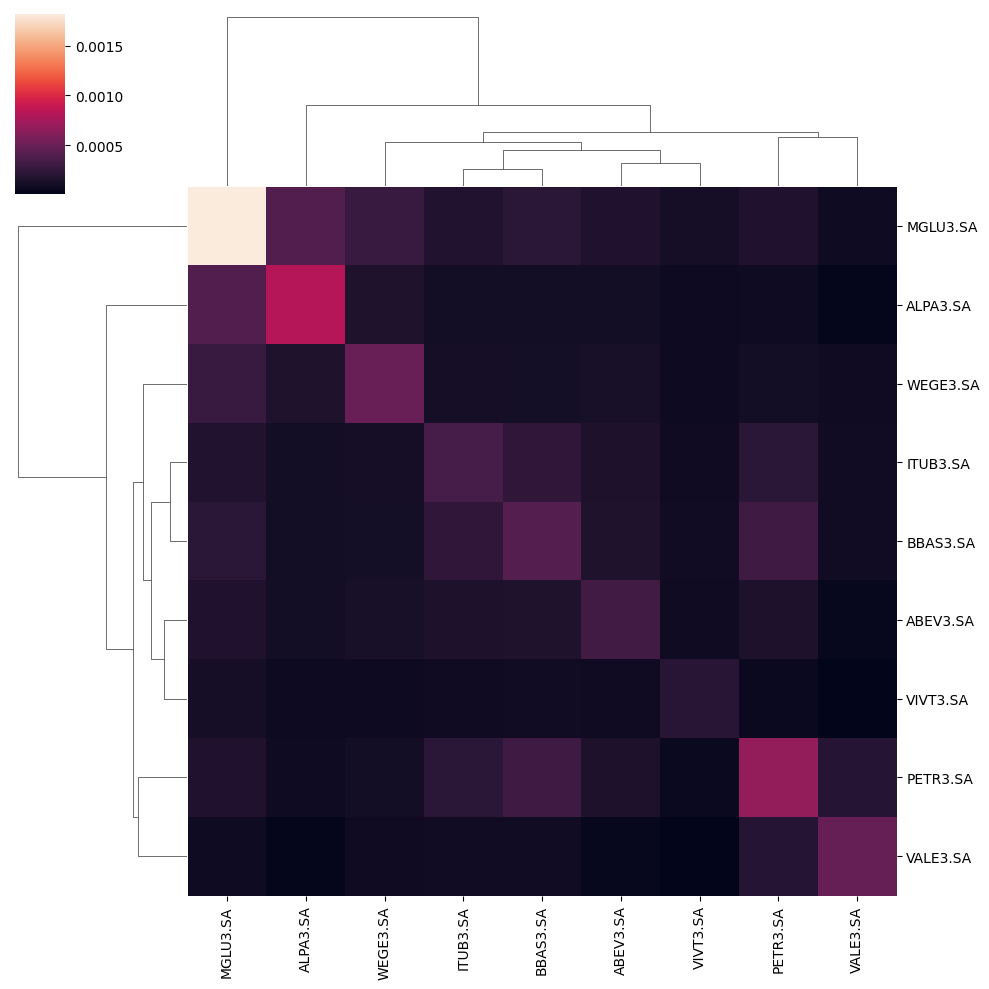

In [181]:
matrix_cov, columns_seriation = matrix_seriation(returns)

In [185]:
def calcula_pesos_hrp(matriz_cov, colunas_seriation):
    # Inicialização de pesos
    pesos = pd.Series(1, index=colunas_seriation)
    paridades = [colunas_seriation]

    while len(paridades) > 0:
        # Instanciação de clusters
        paridades = [cluster[inicio:fim] 
                     for cluster in paridades
                      for inicio, fim in ((0, len(cluster) // 2),(len(cluster) // 2, len(cluster)))
                        if len(cluster) > 1]

        # Iteração entre paridades
        for subcluster in range(0, len(paridades), 2):
            
            cluster_esquerdo = paridades[subcluster]
            cluster_direito = paridades[subcluster + 1]
            
            matriz_cov_esquerda = matriz_cov[cluster_esquerdo].loc[cluster_esquerdo]
            inversa_diagonal = 1 / np.diag(matriz_cov_esquerda.values)
            pesos_cluster_esquerdo = inversa_diagonal / np.sum(inversa_diagonal)
            vol_cluster_esquerdo = np.dot(pesos_cluster_esquerdo, np.dot(matriz_cov_esquerda, pesos_cluster_esquerdo))

            matriz_cov_direita = matriz_cov[cluster_direito].loc[cluster_direito]
            inversa_diagonal = 1 / np.diag(matriz_cov_direita.values)
            pesos_cluster_direito = inversa_diagonal  / np.sum(inversa_diagonal)
            vol_cluster_direito = np.dot(pesos_cluster_direito, np.dot(matriz_cov_direita, pesos_cluster_direito))

            fator_alocacao = 1 - vol_cluster_esquerdo / (vol_cluster_esquerdo + vol_cluster_direito)

            pesos[cluster_esquerdo] *= fator_alocacao
            pesos[cluster_direito] *= 1 - fator_alocacao
            
    return pesos

MGLU3.SA    0.029325
ALPA3.SA    0.065339
WEGE3.SA    0.111423
ITUB3.SA    0.160784
BBAS3.SA    0.101606
ABEV3.SA    0.129024
VIVT3.SA    0.260951
PETR3.SA    0.058946
VALE3.SA    0.082603
dtype: float64

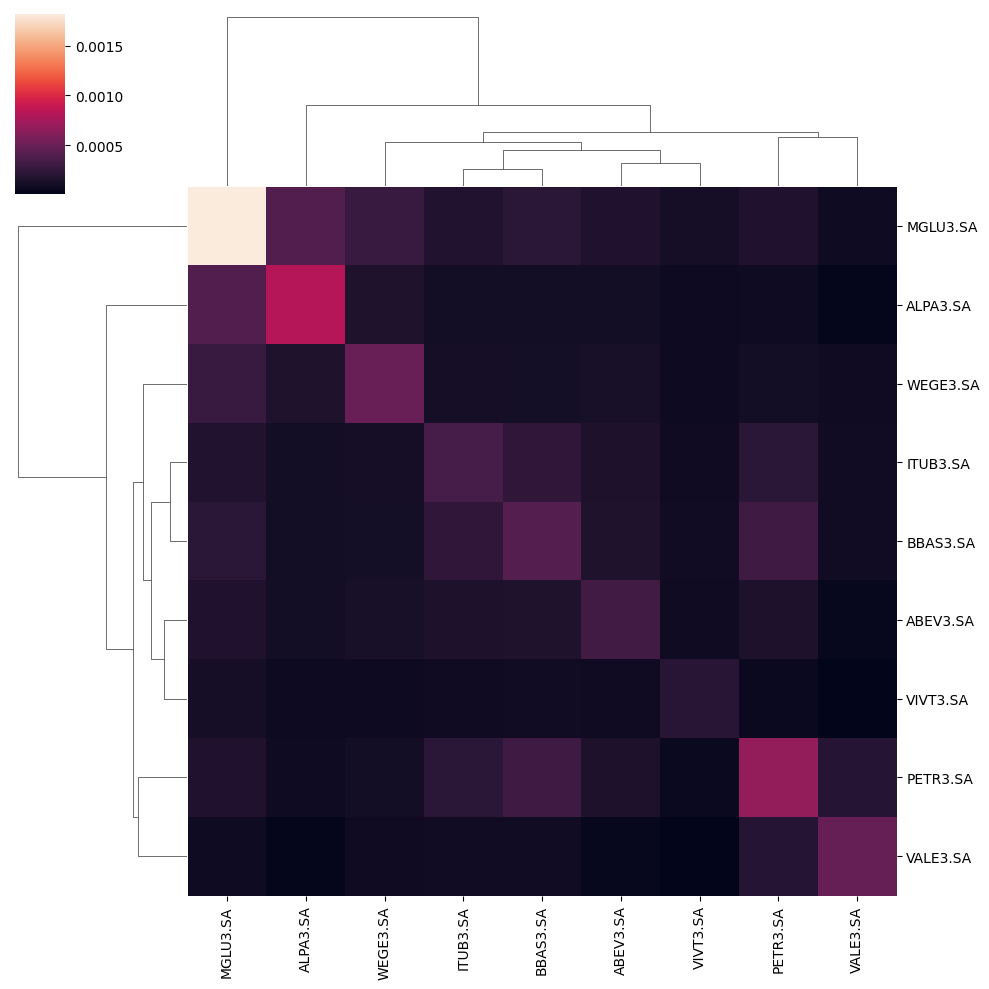

In [275]:
from HRP_portfolio_opt import HRP
hrp = HRP(returns)
hrp.calculate_hrp()

In [277]:
columns_seriation = hrp._columns_s

Index(['MGLU3.SA', 'ALPA3.SA', 'WEGE3.SA', 'ITUB3.SA', 'BBAS3.SA', 'ABEV3.SA',
       'VIVT3.SA', 'PETR3.SA', 'VALE3.SA'],
      dtype='object')

In [218]:
w_hrp = calcula_pesos_hrp(matrix_cov, columns_seriation)
w_hrp = list(w_hrp)
w_hrp

[0.02932473297257073,
 0.06533933629867215,
 0.11142268035961472,
 0.16078369359092048,
 0.10160619718264266,
 0.12902441313233715,
 0.2609508789351686,
 0.05894550020613913,
 0.08260256732193443]

In [278]:
w_sharpe
data.columns
columns_seriation
dict_columns = {}

for columns, value in zip(data.columns, w_hrp):
    
    dict_columns[columns] = w_hrp[list(columns_seriation).index(columns)]
    


In [280]:
weights_ = np.array(list(dict_columns.values()))
sigma_ = cov_portfolio(weights_, cov_matrix)*100
 
ret_ = return_portfolio(weights_, mean).sum() *100
sharp_r_ = (ret_ - tax_w_risk) / sigma_
sharp_r_

0.42406291299077786

In [281]:
#values_hrp = np.dot(np.array(w_hrp) ,1000)
values_hrp = np.dot(weights_,1000)
returns['sharpe otm'] = 0
returns['cla otm'] = 0
returns['max_sqrt otm'] = 0
returns['hrp otm'] = 0


for i in range(len(data)-1):
    sum_all_sharpe = 0
    sum_all_risk = 0
    sum_all_return = 0
    sum_all_hrp = 0
    
    for x in range(len(values_sharpe)):
        
        # sum returns sharpe weights
        sharpe = (1+(returns.iloc[i,x]))* values_sharpe[x]
        sum_all_sharpe = sum_all_sharpe + sharpe
        values_sharpe[x] = sharpe
        
        # sum returns risk weights
        risk = (1+(returns.iloc[i,x]))* values_risk[x]
        sum_all_risk = sum_all_risk + risk
        values_risk[x] = risk
        
        # sum returns return weights
        return_ = (1+(returns.iloc[i,x]))* values_return[x]
        sum_all_return = sum_all_return + return_
        values_return[x] = return_
        
         # sum returns hrp weights
        hrp = (1+(returns.iloc[i,x]))* values_hrp[x]
        sum_all_hrp = sum_all_hrp + hrp
        values_hrp[x] = hrp
        
    returns['sharpe otm'].iloc[i] = sum_all_sharpe
    returns['cla otm'].iloc[i] = sum_all_risk
    returns['max_sqrt otm'].iloc[i] = sum_all_return
    returns['hrp otm'].iloc[i] = sum_all_hrp

C:\Users\prpau\AppData\Local\Temp\ipykernel_12576\3709912111.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  returns['sharpe otm'].iloc[i] = sum_all_sharpe
C:\Users\prpau\AppData\Local\Temp\ipykernel_12576\3709912111.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  returns['cla otm'].iloc[i] = sum_all_risk
C:\Users\prpau\AppData\Local\Temp\ipykernel_12576\3709912111.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  returns[

In [283]:
date_list = []
date_test = list(x.date() for x in returns.index)
start = dt.datetime.strptime(date___, '%d/%m/%Y').date()
day = 30

while start <= end:
    
    if start in date_test:
        date_list.append(start)
    start = start + dt.timedelta(days = 1)
date_list

[datetime.date(2020, 6, 16),
 datetime.date(2020, 6, 17),
 datetime.date(2020, 6, 18),
 datetime.date(2020, 6, 19),
 datetime.date(2020, 6, 22),
 datetime.date(2020, 6, 23),
 datetime.date(2020, 6, 24),
 datetime.date(2020, 6, 25),
 datetime.date(2020, 6, 26),
 datetime.date(2020, 6, 29),
 datetime.date(2020, 6, 30),
 datetime.date(2020, 7, 1),
 datetime.date(2020, 7, 2),
 datetime.date(2020, 7, 3),
 datetime.date(2020, 7, 6),
 datetime.date(2020, 7, 7),
 datetime.date(2020, 7, 8),
 datetime.date(2020, 7, 9),
 datetime.date(2020, 7, 10),
 datetime.date(2020, 7, 13),
 datetime.date(2020, 7, 14),
 datetime.date(2020, 7, 15),
 datetime.date(2020, 7, 16),
 datetime.date(2020, 7, 17),
 datetime.date(2020, 7, 20),
 datetime.date(2020, 7, 21),
 datetime.date(2020, 7, 22),
 datetime.date(2020, 7, 23),
 datetime.date(2020, 7, 24),
 datetime.date(2020, 7, 27),
 datetime.date(2020, 7, 28),
 datetime.date(2020, 7, 29),
 datetime.date(2020, 7, 30),
 datetime.date(2020, 7, 31),
 datetime.date(2020, 

In [284]:
def smooth(y, box_pts):
    
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode = 'valid')
    return y_smooth
       
#plt.title('Performance histórica')
#plt.xlabel('Dias');

In [285]:
ibov = '^BVSP'
day = 365 * 3
ibov_start = dt.date.today() - dt.timedelta(days = day)
df_ibov = yf.download(ibov, start=ibov_start, end=dt.date.today())['Adj Close']
df_ibov

[*********************100%***********************]  1 of 1 completed


Date
2020-06-15     92376.0
2020-06-16     93531.0
2020-06-17     95547.0
2020-06-18     96125.0
2020-06-19     96572.0
                ...   
2023-06-07    115488.0
2023-06-09    117019.0
2023-06-12    117336.0
2023-06-13    116743.0
2023-06-14    119069.0
Name: Adj Close, Length: 746, dtype: float64

In [286]:
sharpe_rent = returns['sharpe otm'] / returns['sharpe otm'][0] -1
cla_rent = returns['cla otm'] / returns['cla otm'][0] -1
max_sqrt_rent = returns['max_sqrt otm'] / returns['max_sqrt otm'][0] -1
hrp_rent = returns['hrp otm'] / returns['hrp otm'][0] -1
ibov_rent = df_ibov / df_ibov[0] -1

In [290]:
# add dados np array 
fdr = smooth(ibov_rent,10)
fdr = np.append(fdr,ibov_rent[-1])

In [291]:
figura = px.line(title = 'Historico')
figura.add_scatter(y = smooth(sharpe_rent,10), name = 'Índice Sharpe')
figura.add_scatter(y = smooth(cla_rent,10), name = 'Mínima Volatilidade')
figura.add_scatter(y = smooth(max_sqrt_rent,10), name = 'Máxima utilidade')
figura.add_scatter(y = smooth(hrp_rent,10), name = 'HRP')
figura.add_scatter(y = smooth(ibov_rent,10), name = 'IBOV')

KeyboardInterrupt: 

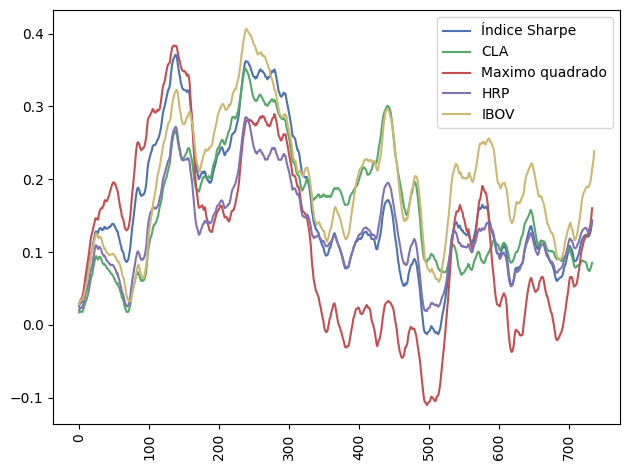

In [292]:
plt.plot( smooth(sharpe_rent,10) );
plt.plot( smooth(cla_rent,10) );
plt.plot( smooth(max_sqrt_rent,10) );
plt.plot( smooth(hrp_rent,10) );
plt.plot( smooth(ibov_rent,10) );
plt.legend(['Índice Sharpe', 'CLA', 'Maximo quadrado', 'HRP', 'IBOV']);
plt.xticks(rotation = 90)
plt.tight_layout();

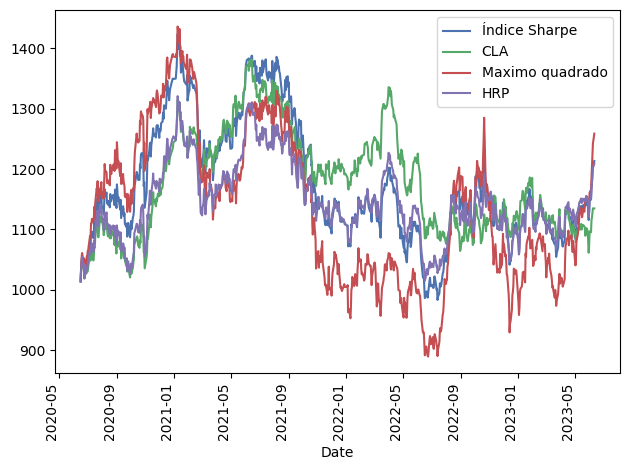

In [293]:
#plt.plot(returns.iloc[:,9:]);
returns.iloc[:,9:].plot(kind = 'line')
plt.legend(['Índice Sharpe', 'CLA', 'Maximo quadrado', 'HRP']);
plt.xticks(rotation = 90)
plt.tight_layout();

In [ ]:
rets = expected_returns.returns_from_prices(data)

In [ ]:
df_ = pd.DataFrame((returns.iloc[-1,-4:] /1000 -1) *100)
df_.columns = ['Rentabilidade']
df_['Rentabilidade'] = list(map(lambda x: f'{round(x,2)}%',df_.values.reshape(-1)))
df_

In [ ]:
# teste função HRP
from pypfopt.hierarchical_portfolio import HRPOpt

ef5 = HRPOpt(rets)
ef5.optimize()
ef5.portfolio_performance(verbose = True)

In [ ]:
# teste 
ef5.clean_weights(), w_hrp

In [ ]:
day = 365 * 3
str(dt.date.today() - dt.timedelta(days = day))

In [ ]:
returns.iloc[-1]

In [356]:
def monte_carlo_projection(data_returns: pd.DataFrame):
    
    # returns percentage
    returns_pct = np.log1p(data_returns[['sharpe otm','cla otm','max_sqrt otm','hrp otm']].pct_change())
    returns_pct.fillna(0, inplace=True)
    
    # calculcates statistics
    mean_mc = returns_pct.mean()
    var_mc = returns_pct.var()
    drift = mean_mc - (0.5 * var_mc)
    std_mc = returns_pct.std()
    
    
    # simulation params 
    years = 3
    days = 252 * years
    simulation = 1000
    
    # random volatility by multidimensional normal distribution
    np.random.seed(0)
    Z = stats.norm.ppf(np.random.rand(days, simulation))
    daily_sharpe = np.exp(drift[0] + std_returns[0] * Z)
    
    np.random.seed(1)
    Z = stats.norm.ppf(np.random.rand(days, simulation))
    daily_risk = np.exp(drift[1] + std_returns[1] * Z)
    
    np.random.seed(2)
    Z = stats.norm.ppf(np.random.rand(days, simulation))
    daily_mqu = np.exp(drift[2] + std_returns[2] * Z)
    
    np.random.seed(3)
    Z = stats.norm.ppf(np.random.rand(days, simulation))
    daily_hrp = np.exp(drift[3] + std_returns[3] * Z)
    
    # the last row every column to predict
    pred_sharpe = np.zeros_like(daily_sharpe)
    pred_sharpe[0] = returns['sharpe otm'][-1]

    pred_risk = np.zeros_like(daily_risk)
    pred_risk[0] = returns['cla otm'][-1]

    pred_mqu = np.zeros_like(daily_mqu)
    pred_mqu[0] = returns['max_sqrt otm'][-1]

    pred_hrp = np.zeros_like(daily_hrp)
    pred_hrp[0] = returns['hrp otm'][-1]
    
    # calculate projections every day
    for day in range(1, days):
      
        pred_sharpe[day] = pred_sharpe[day - 1] * daily_sharpe[day]
        pred_risk[day] = pred_risk[day - 1] * daily_risk[day]
        pred_mqu[day] = pred_mqu[day - 1] * daily_mqu[day]
        pred_hrp[day] = pred_hrp[day - 1] * daily_hrp[day]
        
    
    # melhores projeçoes
    max_sharpe = np.argmax(pred_sharpe[-1,:].flatten())
    max_risk = np.argmax(pred_risk[-1,:].flatten())
    max_mqu = np.argmax(pred_mqu[-1,:].flatten())
    max_hrp = np.argmax(pred_hrp[-1,:].flatten())

    # piores projeções
    min_sharpe = np.argmin(pred_sharpe[-1,:].flatten())
    min_risk = np.argmin(pred_risk[-1,:].flatten())
    min_mqu = np.argmin(pred_mqu[-1,:].flatten())
    min_hrp = np.argmin(pred_hrp[-1,:].flatten())
    
    #return max_sharpe, max_risk, max_mqu, max_hrp, min_sharpe, min_risk, min_mqu, min_hrp
    return [pred_sharpe, pred_risk, pred_mqu, pred_hrp]

In [366]:
listas = monte_carlo_projection(returns)
pred_sharpe, pred_risk, pred_mqu, pred_hrp = listas

pred_sharpe[1][0]

1217.1770066981521

In [352]:
fig = px.line(title = 'Simulações')
for i in range(len(pred_sharpe.T)):
    fig.add_scatter(y = pred_sharpe.T[i], name = [i]);

fig.show()

KeyboardInterrupt: 

In [294]:
returns_data = np.log1p(returns[['sharpe otm','cla otm','max_sqrt otm','hrp otm']].pct_change())
returns_data.fillna(0, inplace=True)

In [295]:
returns_data

,sharpe otm,cla otm,max_sqrt otm,hrp otm
Date,,,,
2020-06-16,0.000000,0.000000,0.000000,0.000000
2020-06-17,0.022646,0.017557,0.022422,0.019602
2020-06-18,0.009591,0.009270,0.014017,0.009793
2020-06-19,0.007521,0.007320,0.007624,0.010035
2020-06-22,-0.011449,-0.012619,-0.013566,-0.015317
...,...,...,...,...
2023-06-05,0.001410,-0.001456,0.003973,0.001465
2023-06-06,0.015384,0.018369,0.015523,0.017098
2023-06-07,0.009383,0.003799,0.014352,0.005027


In [307]:
mean_returns = returns_data.mean()
var_returns = returns_data.var()
drift = mean_returns - (0.5 * var_returns)

In [308]:
years = 3
days = 252 * years
simulation = 1000

In [309]:
std_returns = returns_data.std()

In [337]:
Z = stats.norm.ppf(np.random.rand(days, simulation))
daily_sharpe = np.exp(drift[0] + std_returns[0] * Z)
daily_risk = np.exp(drift[1] + std_returns[1] * Z)
daily_returns = np.exp(drift[2] + std_returns[2] * Z)
daily_hrp = np.exp(drift[3] + std_returns[3] * Z)

In [347]:
np.random.normal(0,days)

216.82135407236612

In [341]:
Z.shape

(756, 1000)

In [370]:
pred_sharpe = np.zeros_like(daily_sharpe)
pred_sharpe[0] = 1000 #returns.iloc[-1,9]

pred_risk = np.zeros_like(daily_risk)
pred_risk[0] = 1000#returns.iloc[-1,10]

pred_returns = np.zeros_like(daily_returns)
pred_returns[0] = 1000#returns.iloc[-1,11]

pred_hrp = np.zeros_like(daily_hrp)
pred_hrp[0] = 1000#returns.iloc[-1,12]

In [371]:
for day in range(1, days):
  #print(dia)
    pred_sharpe[day] = pred_sharpe[day - 1] * daily_sharpe[day]
    pred_risk[day] = pred_risk[day - 1] * daily_risk[day]
    pred_returns[day] = pred_returns[day - 1] * daily_returns[day]
    pred_hrp[day] = pred_hrp[day - 1] * daily_hrp[day]
    

In [406]:
pred_sharpe.flatten().shape

(756000,)

In [424]:
profit_end = len(pred_sharpe[-1][pred_sharpe[-1]>1000])/pred_sharpe.shape[1]
profit_high= len(pred_sharpe[-1][pred_sharpe[-1]>(1000*1.5)])/pred_sharpe.shape[1]

pred_sharpe[1:].mean(), pred_sharpe[1:].std()
#sns.histplot(pred_sharpe.flatten())

(pred_sharpe[1:]/1000).mean(), (pred_sharpe[1:]/1000).std()
#pred_sharpe[-1].mean(), pred_sharpe[-1].std()
#pred_sharpe[-1].min(), pred_sharpe[-1].max()
profit_end, profit_high

(0.624, 0.214)

In [425]:
profit_end = len(pred_risk[-1][pred_risk[-1]>1000])/pred_risk.shape[1]
profit_high= len(pred_risk[-1][pred_risk[-1]>(1000*1.5)])/pred_risk.shape[1]

pred_risk[1:].mean(), pred_risk[1:].std()
#sns.histplot(pred_sharpe.flatten())

(pred_risk[1:]/1000).mean(), (pred_risk[1:]/1000).std()
#pred_risk[-1].mean(), pred_risk[-1].std()
#pred_risk[-1].min(), pred_risk[-1].max()
profit_end, profit_high

(0.577, 0.131)

In [428]:
profit_end = len(pred_returns[-1][pred_returns[-1]>1000])/pred_returns.shape[1]
profit_high= len(pred_returns[-1][pred_returns[-1]>(1000*1.5)])/pred_returns.shape[1]

pred_returns[1:].mean(), pred_returns[1:].std()
#sns.histplot(pred_sharpe.flatten())

(pred_returns[1:]/1000).mean(), (pred_returns[1:]/1000).std()
#pred_returns[-1].mean(), pred_returns[-1].std()
#pred_returns[-1].min(), pred_returns[-1].max()
profit_end, profit_high

(0.594, 0.253)

In [429]:
profit_end = len(pred_hrp[-1][pred_hrp[-1]>1000])/pred_hrp.shape[1]
profit_high= len(pred_hrp[-1][pred_hrp[-1]>(1000*1.5)])/pred_hrp.shape[1]

pred_hrp[1:].mean(), pred_hrp[1:].std()
#sns.histplot(pred_sharpe.flatten())

(pred_hrp[1:]/1000).mean(), (pred_hrp[1:]/1000).std()
pred_hrp[-1].mean(), pred_hrp[-1].std()
pred_hrp[-1].min(), pred_hrp[-1].max()
profit_end, profit_high

(0.652, 0.2)

In [333]:
# melhores projeçoes
max_sharpe = np.argmax(pred_sharpe[-1,:].flatten())
max_risk = np.argmax(pred_risk[-1,:].flatten())
max_retrun = np.argmax(pred_returns[-1,:].flatten())
max_hrp = np.argmax(pred_hrp[-1,:].flatten())

# piores projeções
min_sharpe = np.argmin(pred_sharpe[-1,:].flatten())
min_risk = np.argmin(pred_risk[-1,:].flatten())
min_retrun = np.argmin(pred_returns[-1,:].flatten())
min_hrp = np.argmin(pred_hrp[-1,:].flatten())

np.argmax()

101

In [ ]:
fig = px.line(title = 'Simulações Índice sharpe')

fig.add_scatter(y = pred_sharpe.T[min_sharpe], name = 'Pior projeção');

fig.show()

In [ ]:
fig = px.line(title = 'Simulações CLA')
#for i in range(len(pred_sharpe.T)):
fig.add_scatter(y = pred_risk.T[max_risk], name = 'Melhor projeção');
fig.add_scatter(y = pred_risk.T[min_risk], name = 'Pior projeção');

fig.show()

In [ ]:
fig = px.line(title = 'Simulações Máximo quadrado')
#for i in range(len(pred_sharpe.T)):
fig.add_scatter(y = pred_returns.T[max_retrun], name = 'Melhor projeção');
fig.add_scatter(y = pred_returns.T[min_retrun], name = 'Pior projeção');

fig.show()

In [ ]:
fig = px.line(title = 'Simulações HRP')
#for i in range(len(pred_sharpe.T)):
fig.add_scatter(y = pred_hrp.T[max_hrp], name = 'Melhor projeção');
fig.add_scatter(y = pred_hrp.T[min_hrp], name = 'Pior projeção');

fig.show()

In [60]:
#!pip freeze > requirements.txt

In [143]:
ibov = '^BVSP'
df_ibov = yf.download(ibov, start=dt.date.today() - dt.timedelta(days = day), end=dt.date.today() )['Adj Close']
df_ibov_r = df_ibov.pct_change()
df_ibov_r.dropna(inplace = True)
df_ibov_r.drop(df_ibov_r.index[-1], inplace = True)

dict_betas = dict()
for i in data.columns:
    asset_r = data[i].pct_change()
    asset_r.dropna(inplace = True)
    model = LinearRegression()
    reg = model.fit(df_ibov_r.values.reshape(-1, 1), asset_r.values.reshape(-1, 1))
    beta_asset = reg.coef_[0][0]
    dict_betas[i] = round(beta_asset,2)


[*********************100%***********************]  1 of 1 completed


In [144]:
dict_betas

{'ABEV3.SA': 0.74,
 'PETR3.SA': 1.28,
 'MGLU3.SA': 1.54,
 'ITUB3.SA': 0.94,
 'ALPA3.SA': 0.71,
 'VIVT3.SA': 0.42,
 'WEGE3.SA': 0.81,
 'VALE3.SA': 0.84,
 'BBAS3.SA': 1.06}